# MNISQ VQC — Blind QUantum Computing



In [1]:
#Instale as dependências (descomente e rode se necessário)
!pip install --upgrade qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms scikit-learn matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 53.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.0
    Uninstalling numpy-2.1.0:
      Successfully uninstalled numpy-2.1.0
  Attempting uninstall: scikit-learn━━━━━━━━━━━━ 0/7 [numpy]
    Found existing installation: scikit-learn 1.7.032m0/7 [numpy]
    Uninstalling scikit-learn-1.7.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/7 [scikit-learn]
      Successfully uninstalled scikit-learn-1.7.0━━━━━━━━━━━━━ 1/7 [scikit-learn]
  Attempting uninstall: qiskit0m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/7 [scikit-learn]
    Found existing installation: qiskit 1.2.4━━━━━━━━━━━━━━━━━ 1/7 [sc

In [2]:
# Imports e configurações iniciais
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Visualização inline
%matplotlib inline

# Controle de Aleatoriedade e Reprodutibilidade

In [3]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

try:
    from qiskit_algorithms.utils import algorithm_globals
    algorithm_globals.random_seed = SEED
except Exception as e:
    print("Não foi possível configurar a semente global do Qiskit, continuando...", str(e))


# Callback: envio do circuito por época

In [4]:
# Função de callback que envia circuitos por época — adapte para seu ambiente de rede (ou mantenha como stub).
def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede (stub)...")
    try:
        rede.application_layer.run_app(
            "BFK_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuit=circuito
        )
        print(f"Circuit depth: {circuit_depth}, num_qubits: {num_qubits}")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")


# Inicializar o Backend com Ruído

In [5]:
# Configuração do modelo de ruído e do simulador (AER)
noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)  # 1% 1-qubit
error_2q = depolarizing_error(0.02, 2)  # 2% 2-qubit

# Adiciona erros para portas comuns (ajuste conforme seu conjunto de gates)
noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz', 's', 'sdg', 't', 'tdg'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz', 'swap'])

simulator = AerSimulator(
    noise_model=noise_model,
    shots=1024,
    method='statevector'
)

print('Simulador configurado:', simulator)


Simulador configurado: AerSimulator('aer_simulator_statevector'
             noise_model=<NoiseModel on ['t', 'y', 'rx', 's', 'cx', 'tdg', 'z', 'rz', 'cz', 'x', 'ry', 'sdg', 'swap', 'h']>)


# Carrega o conjunto de dados mnisq


In [6]:
path = "base_test_mnist_784_f90/qasm/"

if not os.path.isdir(path):
    raise FileNotFoundError(f"Diretório não encontrado: {path}. Atualize a variável 'path' com o local correto dos QASM.")

file_list = sorted(os.listdir(path))[:20]  # pega os 20 primeiros arquivos para exemplo

states = []
labels = []

for i, file_name in enumerate(file_list):
    try:
        full_path = os.path.join(path, file_name)
        with open(full_path) as f:
            qasm = f.read()
            qc = QuantumCircuit.from_qasm_str(qasm)
            # salva o statevector no circuito para execução
            qc.save_statevector()
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled)
            result = job.result()
            # dependendo da versão do qiskit, a chave pode variar; tentamos recuperar robustamente:
            try:
                state = result.data(0)['statevector']
            except Exception:
                state = result.get_statevector(compiled)
            features = np.abs(state) ** 2
            features = features[:4]  # reduz para 4 características (exemplo)
            states.append(features)
            labels.append(0 if i < 10 else 1)  # rótulo de exemplo: primeiros 10 -> classe 0, resto -> classe 1
    except Exception as e:
        print(f"Erro ao processar {file_name}: {str(e)}")

X = np.array(states)
y = np.array(labels)

if len(X) == 0:
    raise ValueError("Nenhum dado foi carregado corretamente! Verifique os arquivos QASM e o simulador.")
else:
    print(f"Dados carregados: X.shape={X.shape}, y.shape={y.shape}")


Dados carregados: X.shape=(20, 4), y.shape=(20,)


# Normalização e divisão dos dados

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

num_qubits = X.shape[1]
print(f"Num qubits (features) = {num_qubits}")


Num qubits (features) = 4


# Cria o circuito quântico (FeatureMap + Ansatz)

In [8]:
# Construção do feature map e ansatz
feature_map = ZZFeatureMap(num_qubits, reps=10, entanglement="full")
ansatz = RealAmplitudes(num_qubits, reps=10, entanglement="full")

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

print('Circuito pronto. Depth aproximado:', qc.depth())


Circuito pronto. Depth aproximado: 2


# EstimatorQNN 

In [9]:
estimator = Estimator(options={
    "backend": simulator,
    "resilience_level": 1,
    "approximation": True
})

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
    input_gradients=True
)

vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss=CrossEntropyLoss(),
    optimizer=COBYLA(maxiter=50),
    warm_start=True,
    callback=lambda weights, loss, step: enviar_circuito_por_epoca(
        circuito=feature_map.compose(ansatz.assign_parameters(weights)),
        epoch=step,
        num_qubits=num_qubits,
        circuit_depth=feature_map.compose(ansatz).depth()
    )
)

print('VQC (NeuralNetworkClassifier) configurado.')


VQC (NeuralNetworkClassifier) configurado.


/tmp/ipykernel_36385/3632900870.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={
/tmp/ipykernel_36385/3632900870.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


# Treinamento

In [10]:
# Treinamento — execute quando pronto
print("\nTREINANDO VQC COM BACKEND RUIDOSO...\n")
vqc.fit(X_train, y_train)
print("Treinamento concluído.")


TREINANDO VQC COM BACKEND RUIDOSO...

Treinamento concluído.


# Avaliação: métricas

In [11]:
# Avaliação
print("\nCALCULANDO MÉTRICAS...\n")
y_pred = vqc.predict(X_test)

# Ajustes para formato binário
y_pred = np.round(y_pred).astype(int)
y_pred = np.clip(y_pred, 0, 1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

print("\nMÉTRICAS FINAIS:")
print(f"Acurácia : {accuracy:.4f}")
print(f"Precisão : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nResultados Detalhados:")
print("Entradas:\n", X_test)
print("Saídas Previstas:\n", y_pred)
print("Saídas Reais:\n", y_test)



CALCULANDO MÉTRICAS...


MÉTRICAS FINAIS:
Acurácia : 0.7500
Precisão : 0.6667
Recall   : 1.0000
F1 Score : 0.8000

Resultados Detalhados:
Entradas:
 [[0.02382076 0.06204392 0.00488905 0.        ]
 [0.09984274 0.02038796 0.0134381  0.03818453]
 [0.04744901 0.         0.         0.0345028 ]
 [0.10683771 1.         1.         0.12099313]]
Saídas Previstas:
 [[1]
 [1]
 [1]
 [0]]
Saídas Reais:
 [1 0 1 0]


# Gráfico

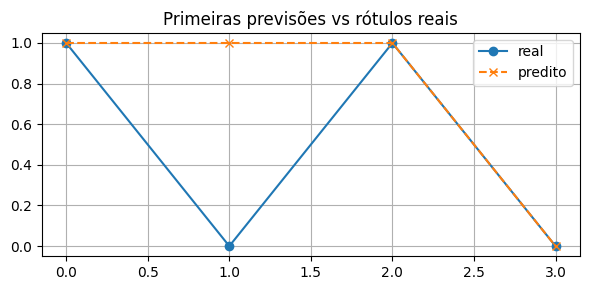

In [12]:
plt.figure(figsize=(6,3))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_test, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()